In [9]:
import numpy as np
import pandas as pd
import string
import nltk
import time

from matplotlib import pyplot as plt

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.util import ngrams

from sklearn.cluster import KMeans, DBSCAN
from sklearn.model_selection import GridSearchCV

rng = np.random

In [10]:
df = pd.read_csv('../data/news_headlines.csv')

print('Total rows: %d\n10 random rows:' % (len(df)))
df.iloc[rng.choice(np.arange(len(df)), 10), :]

Total rows: 1000001
10 random rows:


,publish_date,headline_text
943277,20160120,sharemarket closes near lowest level in two years
748610,20130617,bennett praises losing knights
629880,20120202,more time comment intervention replacement laws
151503,20050713,health inquiry head gets standing ovation
651381,20120823,women lead truckies annual reunion
895307,20150511,couple charged with not sending son to school ...
568196,20110527,clinton urges crackdown on pakistan militants
170071,20050508,police investigate fatal car crash
962006,20170615,eto nabuli named to make wallabies test debut ...
368099,20081216,cousins given afl lifeline


In [11]:
# break dataset by year
print('min date = %d\nmax date = %d' % (np.min(df['publish_date']), np.max(df['publish_date'])))

df_year = {}

for y in np.arange(2003, 2018):
    subdf = df[(df['publish_date'] >= y * 1e4) & (df['publish_date'] < (y + 1) * 1e4)]
    df_year[y] = subdf
    
    print('year %d length = %d' % (y, len(subdf)))

df_year.keys()

min date = 20030219
max date = 20171231
year 2003 length = 59343
year 2004 length = 65975
year 2005 length = 66320
year 2006 length = 61568
year 2007 length = 69431
year 2008 length = 71591
year 2009 length = 68867
year 2010 length = 67715
year 2011 length = 69919
year 2012 length = 78547
year 2013 length = 81016
year 2014 length = 73361
year 2015 length = 70004
year 2016 length = 52162
year 2017 length = 44182


dict_keys([2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017])

total unique words in entire corpus (takes a bit to process): **80570**

``` Python
len(np.unique(word_tokenize(' '.join(df['headline_text']))))
```

In [12]:
# This one takes a little while
def sanitise_words(a):
    '''
    Receives a array of words and sanitises it,
    removing stop words, punctuation and numbers
    (if that is the case).
    '''
    en_stopwords = set(stopwords.words('english'))
    sanitised = []
    
    for w in a:
        # stopwords do not include punctuation
        # isalpha() is also excluding numbers
        # use and (w.isalpha() or w.isnumeric)
        if not w in en_stopwords and w.isalpha():
            sanitised.append(w)
    
    return sanitised


In [13]:
def word_histogram(df):
    '''
    Receives a pandas DataFrame as input (SHOULD RECEIVE AN ARRAY)
    that may be formed by either words or sentences and caculates
    a word histogram considering the whole of its corpus.
    '''
    words = np.array(df['headline_text'])
    words = ' '.join(words)
    words = word_tokenize(words)
    words = sanitise_words(words)
    word_hist = {}
    
    for w in words:
        word_hist[w] = (word_hist.get(w) or 0) + 1
        
    return word_hist


In [ ]:
whist = word_histogram(df)

dfhist = pd.DataFrame.from_dict(whist, orient='index')
dfhist.columns = ['count']
dfhist = dfhist.sort_values('count', ascending=False)

In [ ]:
# plots a line+stem plot with most common words across a dfhist

years = np.arange(2003, 2018)
fig, axes = plt.subplots(len(years), 1, figsize=(18,4 * len(years)))

for i in range(len(years)):
    axes[i].plot(dfhist.iloc[0:40,:], 'o-')
    axes[i].stem(dfhist.iloc[0:40,:])
    axes[i].xticks(rotation=60)

plt.show()

In [35]:
inertias = []
n_clusters = np.arange(5, 31)

for k in n_clusters:
    km = KMeans(n_clusters=k, n_jobs=4, max_iter=300)
    km.fit(data)
    
    inertias.append(km.inertia_)


In [ ]:
KMeans?

In [2]:
from nltk.cluster import KMeansClusterer

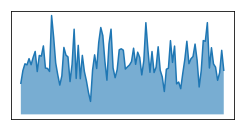

In [72]:
x = np.arange(0, 100, 1)
y = (100 + rng.normal(20, 20, (100,)) + rng.normal(40, 40, (100,)) + rng.normal(60, 60, (100,)) + rng.normal(80, 80, (100,))) / 4


fig, ax = plt.subplots(figsize=(4, 2))
ax.set_xticks([])
ax.set_yticks([])
ax.plot(x, y)
ax.fill_between(x, 0, y, alpha=0.6, clip_on=True)

The basics:
- Tokenise
- Remove stop words
- **Remove numbers?**
- Remove punctuation
- Remove prefixes and suffixes

Wonders:
- Can I use a synonym dictionary to identify equivalence between words? What about each word being synonym of 2 semantically different words? Any examples?


In [51]:
y[y<0]

array([], dtype=float64)

In [54]:
ax.fill_between?

Signature: ax.fill_between(x, y1, y2=0, where=None, interpolate=False, step=None, *, data=None, **kwargs)
Docstring:
Make filled polygons between two curves.


Create a :class:`~matplotlib.collections.PolyCollection`
filling the regions between *y1* and *y2* where
``where==True``

Parameters
----------
x : array
    An N-length array of the x data

y1 : array
    An N-length array (or scalar) of the y data

y2 : array
    An N-length array (or scalar) of the y data

where : array, optional
    If `None`, default to fill between everywhere.  If not `None`,
    it is an N-length numpy boolean array and the fill will
    only happen over the regions where ``where==True``.

interpolate : bool, optional
    If `True`, interpolate between the two lines to find the
    precise point of intersection.  Otherwise, the start and
    end points of the filled region will only occur on explicit
    values in the *x* array.

step : {'pre', 'post', 'mid'}, optional
    If not None, fill with step logi